In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
%matplotlib inline

### Select the .json file to plot

In [2]:
file_path = "../../models/latest/stats.json"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

with open(file_path, "r") as file:
    run_dict = json.load(file)

### Print the model parameters

In [3]:
print("Hyperparameters:")
for key, value in run_dict["hyperparameters"].items():
    print(f"\t{key}: {value}")

print()
print("Architecture:")
for key, value in run_dict["architecture"].items():
    print(f"\t{key}: {value}")
    
print()
print("Statistics:")
print(f"\tTotal number of runs: {run_dict['statistics']['total number of runs']}")
print(f"\tTraining time: {run_dict['statistics']['training time']['hours']:.2f} hours")

Hyperparameters:
	learning_rate: 0.001
	gamma: 0.99
	max_memory: 100000
	batch_size: 128
	epsilon_start: 0.9
	epsilon_end: 0.05
	epsilon_decay: 10000
	update_target_every: 1000
	tau: 0.005
	alpha: 0.7
	beta_start: 0.4
	beta_max: 1.0
	beta_increment_steps: 40000

Architecture:
	inputs: ['section_rel_x', 'section_rel_y', 'next_turn', 'velocity', 'acceleration', 'relative_yaw', 'next_edge_length', 'second_turn']
	outputs: ['release', 'forward', 'right', 'left', 'forward_right', 'forward_left']
	input_size: 8
	output_size: 6
	layer_sizes: [256, 128]
	number_of_hidden_layers: 2
	reward_description: distance travelled projected on the section's x axis (progression on the track)

Statistics:
	Total number of runs: 28148
	Training time: 52.39 hours


### Statistics
#### Overall statistics

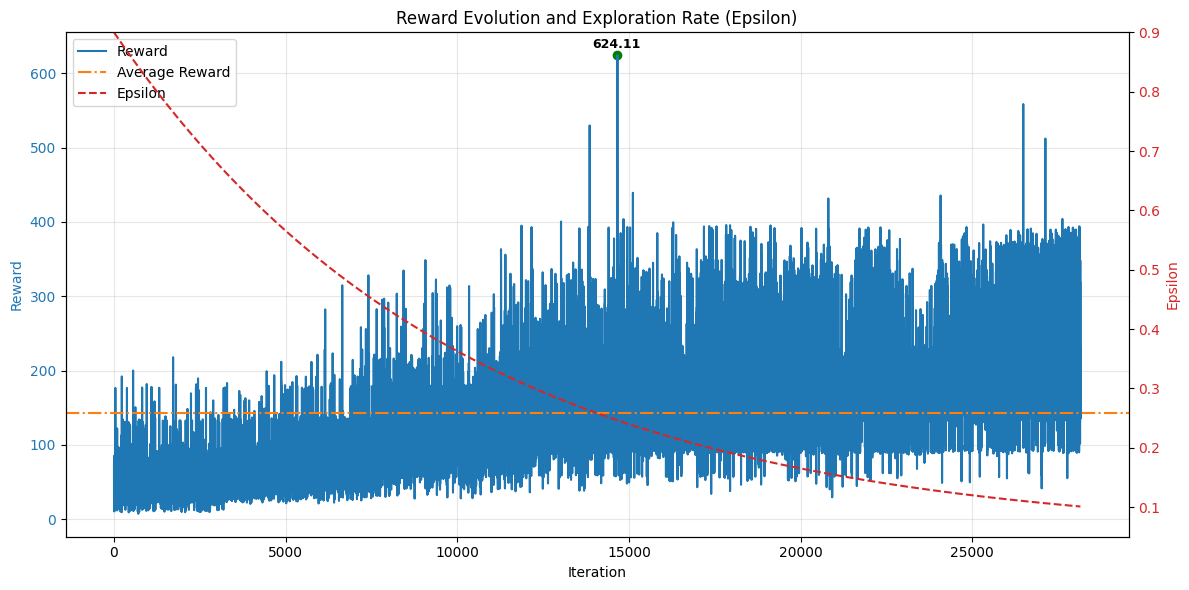

In [4]:
rewards = [run["reward"] for run in run_dict["runs"]]
epsilons = []
number_of_runs = run_dict["statistics"]["total number of runs"]
eps_start = run_dict["hyperparameters"]["epsilon_start"]
eps_end = run_dict["hyperparameters"]["epsilon_end"]
eps_decay = run_dict["hyperparameters"]["epsilon_decay"]
average_reward = run_dict["statistics"]["average reward"]
best_reward = run_dict["statistics"]["best reward"]
best_iteration = np.argmax(rewards)

for i in range(number_of_runs):
    epsilon = eps_end + (eps_start - eps_end) * np.exp(-1. * i / eps_decay)
    epsilons.append(epsilon)

fig, ax1 = plt.subplots(figsize=(12, 6))
color = "tab:blue"
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Reward", color=color)
ax1.plot(rewards, color=color, label="Reward")
ax1.tick_params(axis="y", labelcolor=color)
ax1.grid(True, alpha=0.3)

ax1.axhline(y=average_reward, color='tab:orange', linestyle='-.', label="Average Reward")

ax1.scatter(best_iteration, best_reward, color='g')
ax1.annotate(f"{best_reward:.2f}", 
             xy=(best_iteration, best_reward),
             xytext=(-(len(str(f"{best_reward:.2f}"))) // 3 * 9, 5),  # 10 pixels right of the point
             textcoords='offset points',
             fontsize=9,
             color='k',
             weight='bold')


# Secondary axis - Epsilon
ax2 = ax1.twinx()  # Create a twin x-axis that shares y-axis
color = 'tab:red'
ax2.set_ylabel('Epsilon', color=color)
ax2.set_ylim([eps_end, eps_start])
ax2.plot(epsilons, color=color, linestyle='--', label="Epsilon")
ax2.tick_params(axis='y', labelcolor=color)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Reward Evolution and Exploration Rate (Epsilon)")
plt.tight_layout()
plt.show()



#### Reward frequency

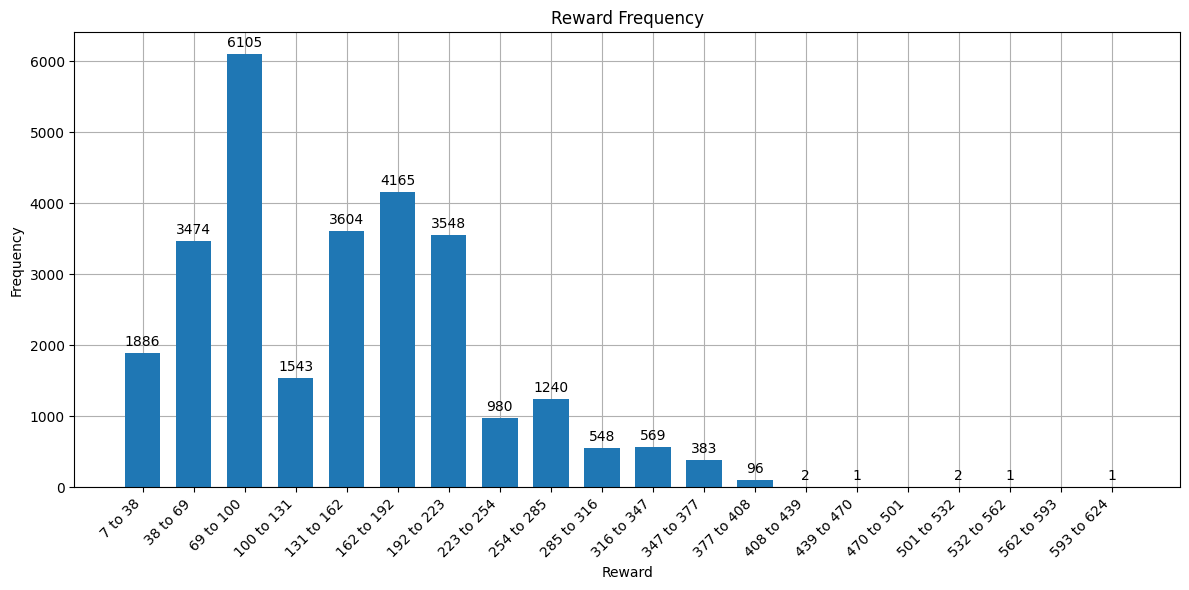

In [5]:
n_bins = 20
hist, bins = np.histogram(rewards, bins=n_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(center, hist, align='center', width=width)

# Format x-tick labels with reward ranges
x_tick_labels = []
for i in range(len(bins)-1):
    x_tick_labels.append(f"{bins[i]:.0f} to {bins[i+1]:.0f}")

# Set the x-tick positions and labels
ax.set_xticks(center)
ax.set_xticklabels(x_tick_labels, rotation=45, ha='right')

# Add count labels above each bar
for bar in bars:
    height = bar.get_height()
    if height > 0:  # Only add labels for bars with data
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_xlabel("Reward")
ax.set_ylabel("Frequency")
plt.title("Reward Frequency")
plt.grid()
ax.set_axisbelow(True)
plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
plt.show()


#### Recent statistics

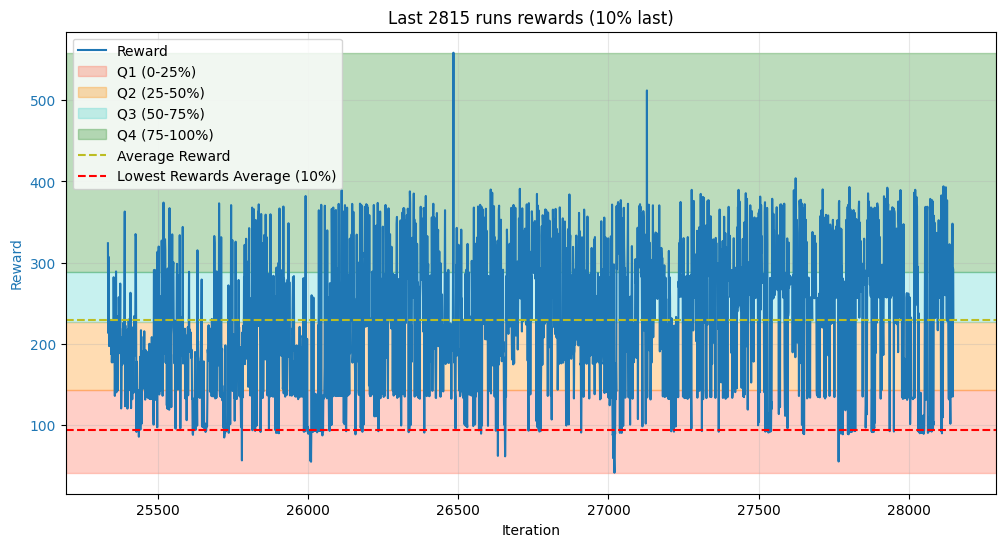

In [6]:
recent_number_of_runs = run_dict["statistics"]["recent average reward"]["number of runs considered"]
recent_number_of_runs_percentage = run_dict["statistics"]["recent average reward"]["percentage of runs considered"] * 100
rewards = [run["reward"] for run in run_dict["runs"][-recent_number_of_runs:]]
iterations = [run["iteration"] for run in run_dict["runs"][-recent_number_of_runs:]]
q25 = run_dict["statistics"]["recent quartiles reward"]["first quartile"]
q50 = run_dict["statistics"]["recent quartiles reward"]["second quartile"]
q75 = run_dict["statistics"]["recent quartiles reward"]["third quartile"]
average_reward = run_dict["statistics"]["recent average reward"]["average reward"]

number_of_worst_runs = run_dict["statistics"]["lowest rewards average"]["number of runs considered"]
lowest_rewards_percentage = run_dict["statistics"]["lowest rewards average"]["percentage of runs considered"] * 100
sorted_indices = np.argsort(rewards)
worst_runs = sorted_indices[:number_of_worst_runs]
worst_rewards = [rewards[i] for i in worst_runs]
worst_rewards_average = run_dict["statistics"]["lowest rewards average"]["average reward"]

min_reward = min(rewards)
max_reward = max(rewards)
x_min, x_max = min(iterations), max(iterations)

fig, ax1 = plt.subplots(figsize=(12, 6))
color = "tab:blue"
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Reward", color=color)
ax1.plot(iterations, rewards, color=color, label="Reward")
ax1.tick_params(axis="y", labelcolor=color)
ax1.grid(True, alpha=0.3)

ax1.axhspan(min_reward, q25, color='tomato', alpha=0.3, label="Q1 (0-25%)")
ax1.axhspan(q25, q50, color='darkorange', alpha=0.3, label="Q2 (25-50%)")
ax1.axhspan(q50, q75, color='mediumturquoise', alpha=0.3, label="Q3 (50-75%)")
ax1.axhspan(q75, max_reward, color='forestgreen', alpha=0.3, label="Q4 (75-100%)")

ax1.axhline(y=average_reward, color='tab:olive', linestyle='--', label="Average Reward")

# ax1.scatter(worst_runs + number_of_runs - recent_number_of_runs + 1, worst_rewards, color='r', label="Lowest Rewards")
ax1.axhline(y=worst_rewards_average, color='r', linestyle='--', label=f"Lowest Rewards Average ({lowest_rewards_percentage:.0f}%)")

plt.title(f"Last {recent_number_of_runs} runs rewards ({recent_number_of_runs_percentage:.0f}% last)")
plt.legend()
plt.show()